In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [2]:
pd.set_option('display.max_rows', 1500)
pd.set_option('display.max_columns', 1000)

# Import Data

#### For this prediction, I will try to use all the features except Id

In [3]:
df = pd.read_csv('../datasets/clean_train.csv')
kaggle_test = pd.read_csv('../datasets/clean_test.csv')

In [4]:
# first of all I will dummify both the training and test data sets
dummy_train = pd.get_dummies(df, drop_first=True)
dummy_kaggle_test = pd.get_dummies(kaggle_test, drop_first=True)

In [5]:
dummy_train.shape, dummy_kaggle_test.shape

((2051, 245), (878, 230))

In [6]:
len(dummy_train.columns)

245

In [7]:
a = np.array(dummy_train.columns)
b = np.array(dummy_kaggle_test.columns)

In [8]:
# Making sure that both dataframes have same columns after being dummified
for val in a:
    if val == 'SalePrice':
        continue
    elif val not in b:
        dummy_train.drop(columns=val, axis=1, inplace=True)

In [9]:
for val in b:
    if val not in a:
        dummy_kaggle_test.drop(columns=val, axis=1, inplace=True)

In [10]:
dummy_train.shape, dummy_kaggle_test.shape

((2051, 221), (878, 220))

In [11]:
# creating an array of features for later use
ft = np.array(dummy_train.drop(columns=['Id','PID', 'SalePrice'], axis=1).columns)

In [12]:
ft

array(['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'MS Zoning_FV',
       'MS Zoning_I (all)', 'MS Zoning_RH', 'MS Zoning_RL',
       'MS Zoning_RM', 'Street_Pave', 'Lot Shape_IR2', 'Lot Shape_IR3',
       'Lot Shape_Reg', 'Land Contour_HLS', 'Land Contour_Low',
       'Land Contour_Lvl', 'Utilities_NoSewr', 'Lot Config_CulDSac',
       'Lot Config_FR2', 'Lot Config_FR3', 'Lot Config_Inside',
       'Land Slope_Mod', 'Land Slope_Sev'

In [13]:
def random_scores(model, df, valid_df, target, feat_input=[], feat_count=0, trials=1, test_size=.25, random_state=42):
    """
    generate different outcomes from randomly selected features or input features for different models
    """
    scores = []
    for i in range(trials):
        features = feat_input
        if len(feat_input) == 0:
            features = []
        # populate random features list
            while len(features) < feat_count:
                feature = np.random.choice(df.columns)
                if feature not in features:
                    features.append(feature)
    
        # train test split
        X = df[features]
        y = target
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        
        # Scale data
        sc = StandardScaler()
        Xs_train = sc.fit_transform(X_train)
        Xs_test = sc.transform(X_test)
        Xs_kaggle = sc.transform(valid_df[features])
        
        
        if model == 'LinearRegression':
            # Instantiate and fit the model
            lr = LinearRegression()
            lr.fit(Xs_train, y_train)

            # Check r2 score
            r2_train = lr.score(Xs_train, y_train)
            r2_test = lr.score(Xs_test, y_test)

            # Cross val score
            cross_val = cross_val_score(lr, Xs_train, y_train).mean()
        
        
            # predict
            y_preds_kaggle = lr.predict(Xs_kaggle)
            y_preds = lr.predict(Xs_test)


            # add data to scores list
            scores.append({
                            'y_test': y_test,
                            'r2_train': r2_train,
                          'r2_test': r2_test,
                          'cross_val': cross_val,
                        'y_preds': y_preds, 
                        'y_preds_kaggle': y_preds_kaggle,
                            'coef_': lr.coef_})
            
        elif model == 'Ridge':
            # Instantiate and fit the model
                ridge = Ridge(alpha=10, max_iter=100000)
                ridge.fit(Xs_train, y_train)

                # Check r2 score
                r2_train = ridge.score(Xs_train, y_train)
                r2_test = ridge.score(Xs_test, y_test)


                # predict
                y_preds_kaggle = ridge.predict(Xs_kaggle)
                y_preds = ridge.predict(Xs_test)


                # add data to scores list
                scores.append({
                                'y_test': y_test,
                                'r2_train': r2_train,
                              'r2_test': r2_test,
                            'y_preds': y_preds, 
                            'y_preds_kaggle': y_preds_kaggle,
                                'coef_': ridge.coef_})
        elif model == 'Lasso':
             # Instantiate and fit the model
                lasso = Lasso(alpha=10, max_iter=100000)
                lasso.fit(Xs_train, y_train)

                # Check accuracy
                acc_train = lasso.score(Xs_train, y_train)
                acc_test = lasso.score(Xs_test, y_test)


                # predict
                y_preds_kaggle = lasso.predict(Xs_kaggle)
                y_preds = lasso.predict(Xs_test)


                # add data to scores list
                scores.append({
                                'y_test': y_test,
                                'r2_train': acc_train,
                              'r2_test': acc_test,
                            'y_preds': y_preds, 
                            'y_preds_kaggle': y_preds_kaggle,
                                'coef_': lasso.coef_})
        
    return scores
        
        

### The first evaluation was made on all the features --> ft

In [14]:
sub1lr = random_scores(model='LinearRegression', df=dummy_train.drop(columns=['Id', 'SalePrice'], axis=1),
              valid_df=dummy_kaggle_test, target=dummy_train['SalePrice'], feat_input=ft)



In [15]:
ridge1 = random_scores(model='Ridge',df=dummy_train.drop(columns=['Id', 'SalePrice'], axis=1),
              valid_df=dummy_kaggle_test, target=dummy_train['SalePrice'], 
            feat_input=ft)



In [16]:
lasso1 = random_scores(model='Lasso',df=dummy_train.drop(columns=['Id', 'SalePrice'], axis=1),
              valid_df=dummy_kaggle_test, target=dummy_train['SalePrice'], 
            feat_input=ft)

In [17]:
# RMSE Linear
y_test1 = sub1lr[0]['y_test']
y_preds1 = sub1lr[0]['y_preds']
(metrics.mean_squared_error(y_test1, y_preds1))**0.5

23966518878606.773

In [18]:
# RMSE Ridge
y_test1ridge = ridge1[0]['y_test']
y_preds1ridge = ridge1[0]['y_preds']
(metrics.mean_squared_error(y_test1ridge, y_preds1ridge))**0.5

25388.874012009885

In [19]:
# RMSE Lasso
y_test1lasso = lasso1[0]['y_test']
y_preds1lasso = lasso1[0]['y_preds']
(metrics.mean_squared_error(y_test1lasso, y_preds1lasso))**0.5

25475.40910675725

Looking at the rmse linear regression is performing worse compared to the ridge and lasso models.
RMSE for ridge and lasso are close

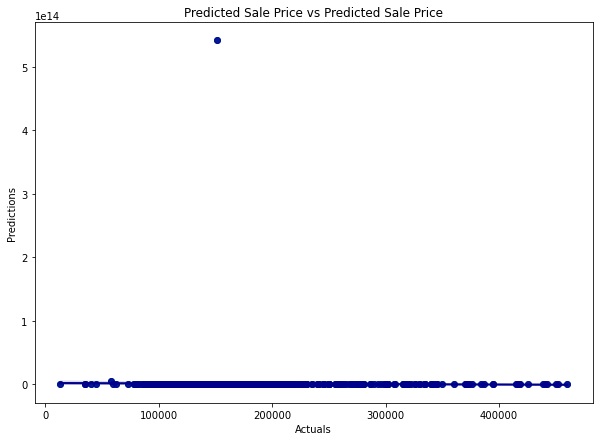

In [20]:
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(y_test1, y_preds1)
sns.regplot(x=y_test1, y=y_preds1, color='darkblue')
ax.set(title='Predicted Sale Price vs Predicted Sale Price', xlabel='Actuals', ylabel='Predictions');

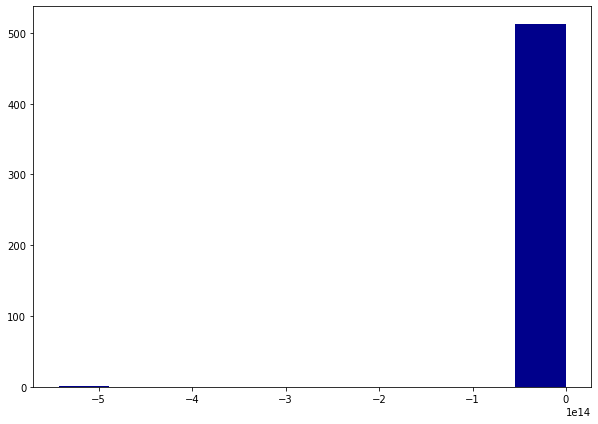

In [21]:
resids = y_test1 - y_preds1
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(resids, color='darkblue');

Along with the RMSE being too big, the graphs don't show a linear relationhip nor a normal distribution. One of the reasons could be a very strong multicollinearity between the features

In [22]:
# getting the coefficients for each feature
new_cols = []
for i, cof in enumerate(sub1lr[0]['coef_']):
    if cof > 1:
        new_cols.append({ft[i]: cof})

In [23]:
new_cols

[{'Lot Area': 2127.056471154351},
 {'Overall Qual': 10024.523659369612},
 {'Overall Cond': 4469.932967977891},
 {'Year Built': 4428.440847034132},
 {'Year Remod/Add': 1221.2985434459033},
 {'Mas Vnr Area': 4078.7117417351847},
 {'BsmtFin SF 1': 328854001404951.2},
 {'BsmtFin SF 2': 119158257664664.34},
 {'Bsmt Unf SF': 310955723263036.1},
 {'Gr Liv Area': 961994588193366.6},
 {'Bsmt Full Bath': 4262.1142578125},
 {'Bsmt Half Bath': 343.6490478515625},
 {'Full Bath': 4272.242919921875},
 {'Half Bath': 2683.671875},
 {'Bedroom AbvGr': 300.5546875},
 {'TotRms AbvGrd': 2655.3203125},
 {'Fireplaces': 3741.8671875},
 {'Garage Cars': 6111.068359375},
 {'Garage Area': 257.591796875},
 {'Wood Deck SF': 1301.609375},
 {'Open Porch SF': 74.68359375},
 {'Enclosed Porch': 854.240234375},
 {'3Ssn Porch': 1215.6689453125},
 {'Screen Porch': 4331.357421875},
 {'Yr Sold': 106.5107421875},
 {'MS Zoning_FV': 2818.375},
 {'MS Zoning_I (all)': 91132199370669.56},
 {'MS Zoning_RH': 1867.80078125},
 {'MS Zon

In [24]:
# Write to file
sub1_df = pd.DataFrame({'Id': dummy_kaggle_test['Id'], 'SalePrice': sub1lr[0]['y_preds_kaggle']})
sub1_df = sub1_df.sort_values(by='Id', ascending='True')
sub1_df.reset_index(inplace=True, drop=True)
sub1_df.to_csv('../predictions/submission1.csv', index=False)

### Evaluation 2 --> choosing only numerical features

In [25]:
sub2lr = random_scores(model='LinearRegression', df=dummy_train.drop(columns=['Id', 'SalePrice'], axis=1),
              valid_df=dummy_kaggle_test, target=dummy_train['SalePrice'], 
            feat_input=['Fireplaces', 'Lot Area', 'Mas Vnr Area', 'Total Bsmt SF', 'Gr Liv Area', 'Year Remod/Add', 'Garage Cars', 'Wood Deck SF'])

ridge2 = random_scores(model='Ridge', df=dummy_train.drop(columns=['Id', 'SalePrice'], axis=1),
              valid_df=dummy_kaggle_test, target=dummy_train['SalePrice'], 
            feat_input=['Fireplaces', 'Lot Area', 'Mas Vnr Area', 'Total Bsmt SF', 'Gr Liv Area', 'Year Remod/Add', 'Garage Cars', 'Wood Deck SF'])

lasso2 = random_scores(model='Lasso', df=dummy_train.drop(columns=['Id', 'SalePrice'], axis=1),
              valid_df=dummy_kaggle_test, target=dummy_train['SalePrice'], 
            feat_input=['Fireplaces', 'Lot Area', 'Mas Vnr Area', 'Total Bsmt SF', 'Gr Liv Area', 'Year Remod/Add', 'Garage Cars', 'Wood Deck SF'])

In [26]:
# RMSE Linear Regression
y_preds2 = sub2lr[0]['y_preds'] 
y_test2 = sub2lr[0]['y_test']
(metrics.mean_squared_error(y_test2, y_preds2))**0.5

34959.693205316384

In [27]:
# RMSE Ridge
y_test2ridge = ridge2[0]['y_test']
y_preds2ridge = ridge2[0]['y_preds']
(metrics.mean_squared_error(y_test2ridge, y_preds2ridge))**0.5

34982.22679590287

In [28]:
# RMSE Lasso
y_test2lasso = lasso2[0]['y_test']
y_preds2lasso = lasso2[0]['y_preds']
(metrics.mean_squared_error(y_test2lasso, y_preds2lasso))**0.5

34961.394055872

The RMSE is definitely better than the 1st time for Linear Regression. All the RMSE's are close

In [29]:
cross2 = sub2lr[0]['cross_val']
cross2

0.7131358077964072

In [30]:
r2_train2 = sub2lr[0]['r2_train']
r2_train2

0.7373712255303921

In [31]:
r2_test2 = sub2lr[0]['r2_test']
r2_test2

0.8009486601940843

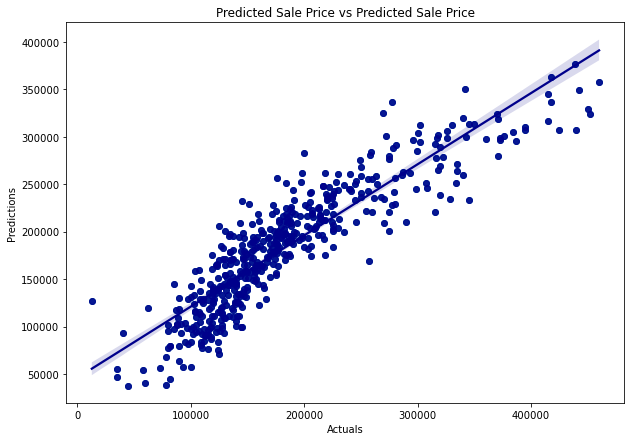

In [32]:
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(y_test2, y_preds2)
sns.regplot(x=y_test2, y=y_preds2, color='darkblue')
ax.set(title='Predicted Sale Price vs Predicted Sale Price', xlabel='Actuals', ylabel='Predictions');

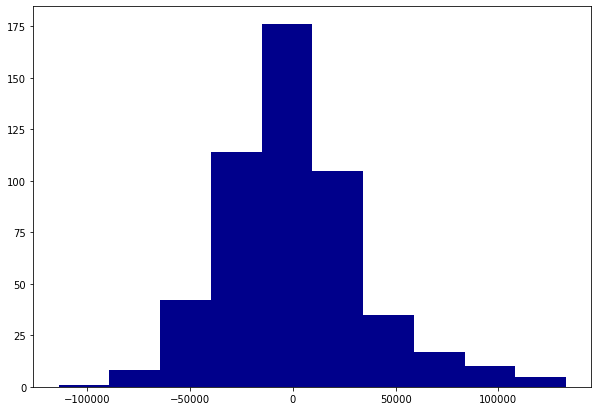

In [33]:
resids = y_test2 - y_preds2
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(resids, color='darkblue');

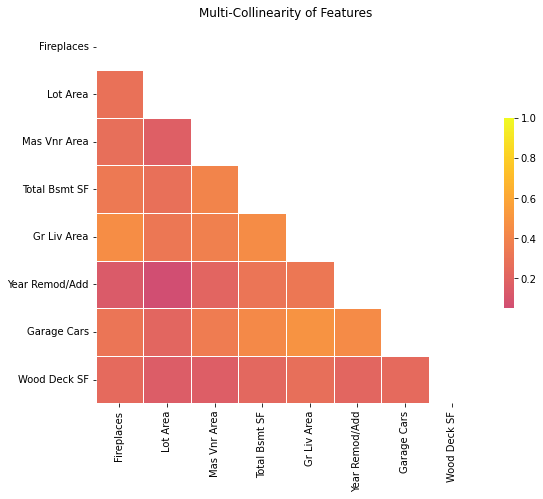

In [34]:
# Create a covariance matrix
corr = dummy_train[['Fireplaces', 'Lot Area', 'Mas Vnr Area', 'Total Bsmt SF', 'Gr Liv Area', 'Year Remod/Add', 'Garage Cars', 'Wood Deck SF']].corr()
# Creating a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 7))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,vmax=1,center=0,square=True, 
            linewidth=.5, cbar_kws={'shrink': .5}, cmap='plasma')
ax.set_title('Multi-Collinearity of Features');

In [35]:
# Saving as csv for submission to kaggle
sub2_df = pd.DataFrame({'Id': dummy_kaggle_test['Id'], 'SalePrice': sub2lr[0]['y_preds_kaggle']})
sub2_df = sub2_df.sort_values(by='Id', ascending='True')
sub2_df.reset_index(inplace=True, drop=True)
sub2_df.to_csv('../predictions/submission2.csv', index=False)

### Evaluation 3 --> Using both categorical and numerical values

In [36]:
sub3lr = random_scores(model='LinearRegression', df=dummy_train.drop(columns=['Id', 'SalePrice'], axis=1),
              valid_df=dummy_kaggle_test, target=dummy_train['SalePrice'], 
            feat_input=['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'Bsmt Full Bath',
                        'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Fireplaces', 'Bedroom AbvGr'
                        ])

ridge3 = random_scores(model='Ridge', df=dummy_train.drop(columns=['Id', 'SalePrice'], axis=1),
              valid_df=dummy_kaggle_test, target=dummy_train['SalePrice'], 
            feat_input=['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'Bsmt Full Bath',
                        'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Fireplaces', 'Bedroom AbvGr'
                        ])

lasso3 = random_scores(model='Lasso', df=dummy_train.drop(columns=['Id', 'SalePrice'], axis=1),
              valid_df=dummy_kaggle_test, target=dummy_train['SalePrice'], 
            feat_input=['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'Bsmt Full Bath',
                        'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Fireplaces', 'Bedroom AbvGr'
                        ])

In [37]:
sub3lr[0]['cross_val'], sub3lr[0]['r2_test'],sub3lr[0]['r2_train'],

(0.7489471908333049, 0.7445393961457286, 0.7647921680971058)

In [38]:
# RMSE Linear Regression
y_preds3 = sub3lr[0]['y_preds'] 
y_test3 = sub3lr[0]['y_test']
(metrics.mean_squared_error(y_test3, y_preds3))**0.5

39604.72730982234

In [39]:
# RMSE Ridge
y_test3ridge = ridge3[0]['y_test']
y_preds3ridge = ridge3[0]['y_preds']
(metrics.mean_squared_error(y_test3ridge, y_preds3ridge))**0.5

39586.58000814927

In [40]:
# RMSE Lasso
y_test3lasso = lasso3[0]['y_test']
y_preds3lasso = lasso3[0]['y_preds']
(metrics.mean_squared_error(y_test3lasso, y_preds3lasso))**0.5

39599.755010460096

The RMSE is greater than the previous, it is probably because of multicollinearity and the fact that the coefficients for some of the features are not good enough to explain the variability in the target saleprice

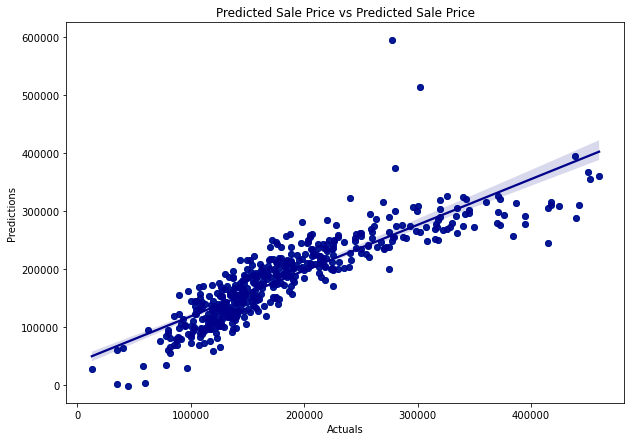

In [41]:
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(y_test3, y_preds3)
sns.regplot(x=y_test3, y=y_preds3, color='darkblue')
ax.set(title='Predicted Sale Price vs Predicted Sale Price', xlabel='Actuals',
       ylabel='Predictions');

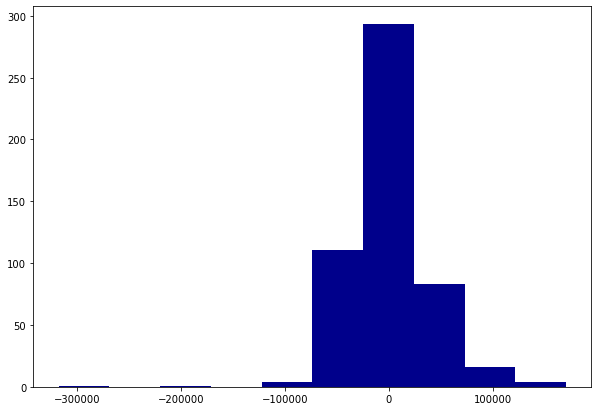

In [42]:
resids = y_test3 - y_preds3
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(resids, color='darkblue');

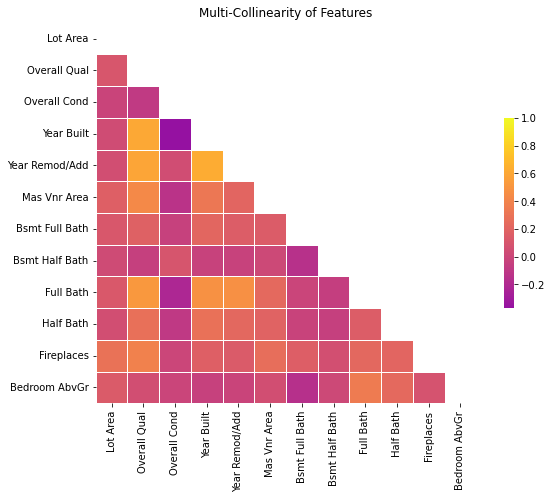

In [43]:
# Create a covariance matrix
corr = dummy_train[['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'Bsmt Full Bath',
                        'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Fireplaces', 'Bedroom AbvGr'
                        ]].corr()
# Creating a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 7))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,vmax=1,center=0,square=True, 
            linewidth=.5, cbar_kws={'shrink': .5}, cmap='plasma')
ax.set_title('Multi-Collinearity of Features');

In [44]:
# Saving as csv for submission to kaggle
sub3_df = pd.DataFrame({'Id': dummy_kaggle_test['Id'], 'SalePrice': sub3lr[0]['y_preds_kaggle']})
sub3_df = sub3_df.sort_values(by='Id', ascending='True')
sub3_df.reset_index(inplace=True, drop=True)
sub3_df.to_csv('../predictions/submission3.csv', index=False)

### Evaluation 4 --> Using both categorical and numerical values but choosing them according to higher coefficients

In [45]:
sub4lr = random_scores(model='LinearRegression',df=dummy_train.drop(columns=['Id', 'SalePrice'], axis=1),
              valid_df=dummy_kaggle_test, target=dummy_train['SalePrice'], 
            feat_input=['Sale Type_New', 'Full Bath', 'Bsmt Exposure_Gd',  'Roof Style_Hip', 'House Style_1Story', 'Condition 1_Norm',
                        'Garage Cars', 'Year Built', 'Fireplaces','Neighborhood_StoneBr', 'Neighborhood_NridgHt', 'Neighborhood_NoRidge','Lot Area',
                        'Mas Vnr Area', 'Overall Qual', 'Overall Cond', 'Garage Cars', 'Screen Porch', 'MS Zoning_RL'])

ridge4 = random_scores(model='Ridge',df=dummy_train.drop(columns=['Id', 'SalePrice'], axis=1),
              valid_df=dummy_kaggle_test, target=dummy_train['SalePrice'], 
            feat_input=['Sale Type_New', 'Full Bath', 'Bsmt Exposure_Gd',  'Roof Style_Hip', 'House Style_1Story', 'Condition 1_Norm',
                        'Garage Cars', 'Year Built', 'Fireplaces','Neighborhood_StoneBr', 'Neighborhood_NridgHt', 'Neighborhood_NoRidge','Lot Area',
                        'Mas Vnr Area', 'Overall Qual', 'Overall Cond', 'Garage Cars', 'Screen Porch', 'MS Zoning_RL'])

lasso4 = random_scores(model='Lasso',df=dummy_train.drop(columns=['Id', 'SalePrice'], axis=1),
              valid_df=dummy_kaggle_test, target=dummy_train['SalePrice'], 
            feat_input=['Sale Type_New', 'Full Bath', 'Bsmt Exposure_Gd',  'Roof Style_Hip', 'House Style_1Story', 'Condition 1_Norm',
                        'Garage Cars', 'Year Built', 'Fireplaces','Neighborhood_StoneBr', 'Neighborhood_NridgHt', 'Neighborhood_NoRidge','Lot Area',
                        'Mas Vnr Area', 'Overall Qual', 'Overall Cond', 'Garage Cars', 'Screen Porch', 'MS Zoning_RL'])

In [46]:
sub4lr[0]['cross_val'], sub4lr[0]['r2_test'],sub4lr[0]['r2_train'],

(0.8031461275679549, 0.7959286058323941, 0.8173306015721906)

In [47]:
# RMSE Linear Regression
y_preds4 = sub4lr[0]['y_preds'] 
y_test4 = sub4lr[0]['y_test']
(metrics.mean_squared_error(y_test4, y_preds4))**0.5

35397.788164490266

In [48]:
# RMSE Ridge
y_test4ridge = ridge4[0]['y_test']
y_preds4ridge = ridge4[0]['y_preds']
(metrics.mean_squared_error(y_test4ridge, y_preds4ridge))**0.5

35299.93109419696

The RMSE has improved from the previous evaluation but still needs work

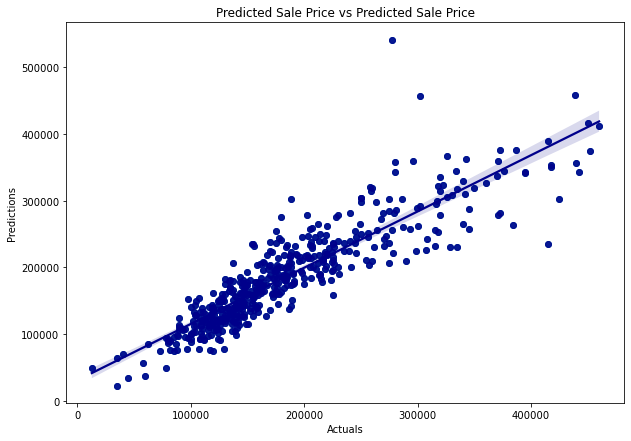

In [49]:
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(y_test4, y_preds4)
sns.regplot(x=y_test4, y=y_preds4, color='darkblue')
ax.set(title='Predicted Sale Price vs Predicted Sale Price', xlabel='Actuals',
       ylabel='Predictions');

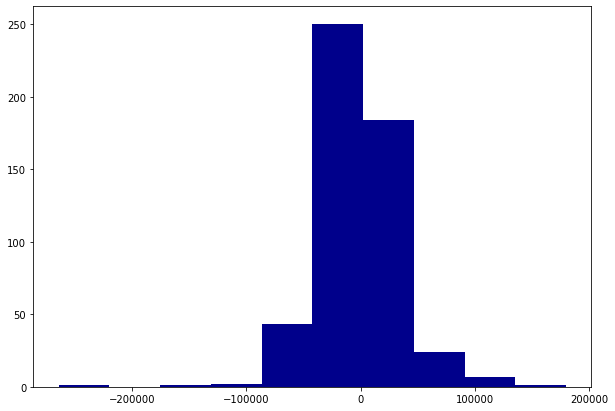

In [50]:
resids = y_test4 - y_preds4
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(resids, color='darkblue');

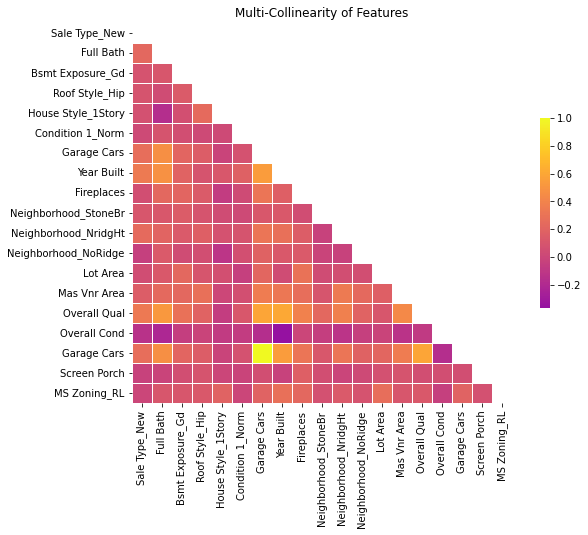

In [51]:
# Create a covariance matrix
corr = dummy_train[['Sale Type_New', 'Full Bath', 'Bsmt Exposure_Gd',  'Roof Style_Hip', 'House Style_1Story', 'Condition 1_Norm',
                        'Garage Cars', 'Year Built', 'Fireplaces','Neighborhood_StoneBr', 'Neighborhood_NridgHt', 'Neighborhood_NoRidge','Lot Area',
                        'Mas Vnr Area', 'Overall Qual', 'Overall Cond', 'Garage Cars', 'Screen Porch', 'MS Zoning_RL']].corr()
# Creating a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 7))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,vmax=1,center=0,square=True, 
            linewidth=.5, cbar_kws={'shrink': .5}, cmap='plasma')
ax.set_title('Multi-Collinearity of Features');

In [52]:
# Saving as csv for submission to kaggle
sub4_df = pd.DataFrame({'Id': dummy_kaggle_test['Id'], 'SalePrice': sub4lr[0]['y_preds_kaggle']})
sub4_df = sub4_df.sort_values(by='Id', ascending='True')
sub4_df.reset_index(inplace=True, drop=True)
sub4_df.to_csv('../predictions/submission4.csv', index=False)

Although the rmse score has gotten better, one thing which could have been done is hyperparameter tuning for the lasso and ridge models.